# 02/08/24 - Shawn
## This notebook creates a stellar population model from Xshooter templates for use with ppxf's sps_util.py

## Libraries

In [1]:
from astropy.io import fits
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

## Directories

In [2]:
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
lib_dir = f'{data_dir}xshooter_lib/all_dr2_fits/'

# View the data

## See what I've already made (which might not be right)

In [3]:
# load the fits file, see what it looks like

filepath = f'{lib_dir}templates_stellar_library_test.fits'

with open(filepath, 'rb') as file:
    hdul = fits.open(file)
    data = hdul[0].data

In [4]:
data.shape

(11191, 628)

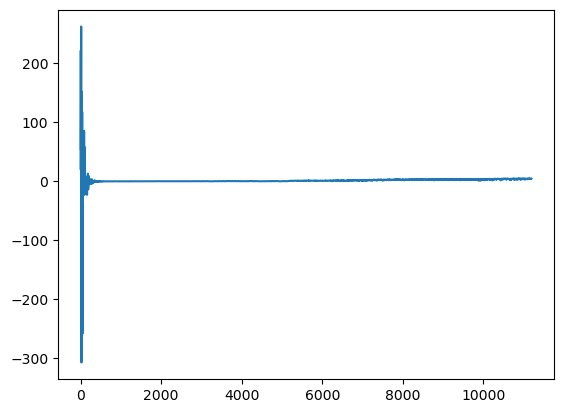

In [5]:
# It looks like it's an array of 628 stars with 11191 datapoints
# Look at one

plt.plot(data[:,0])

## Open one of the individual files

In [6]:
filepath = f'{lib_dir}xsl_spectrum_X0002_uvb.fits'

with open(filepath, 'rb') as file:
    hdul = fits.open(file)
    print(hdul.info())
    hdu0 = hdul[0]
    hdu1 = hdul[1]
    hdr0 = hdu0.header
    hdr1 = hdu1.header
    data = hdu1.data

Filename: /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/xshooter_lib/all_dr2_fits/xsl_spectrum_X0002_uvb.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  SPECTRUM      1 BinTableHDU     43   17140R x 3C   [E, E, E]   
None


In [7]:
template_wavelengths = data['wave']*10

In [8]:
data['flux']

array([-1.1070487e-11, -9.6795722e-12, -1.4454830e-11, ...,
        2.4743226e-15,  2.4480142e-15,  2.3374715e-15], dtype='>f4')

In [9]:
hdr0['spec_bin']

0.01499275053767608

## We just need the wavelengths and spectrum from each of the uvb files

In [10]:
# There should be 628 of them

filepaths = np.array(glob(f'{lib_dir}*uvb.fits'))
filepaths.shape

(628,)

In [47]:
filepaths.sort()

In [11]:
# create an array of shape (# wavelengths, # of tempaltes)
templates = np.zeros((template_wavelengths.shape[0], filepaths.shape[0]))

In [42]:
wavelengths

array([2989.0967, 2989.2466, 2989.3967, ..., 5559.687 , 5559.837 ,
       5559.9863], dtype='>f4')

In [43]:
template_wavelengths

array([2987.6052, 2987.7554, 2987.9053, ..., 5556.913 , 5557.063 ,
       5557.213 ], dtype=float32)

In [59]:
wavelengths_array = np.zeros((len(template_wavelengths), len(filepaths)))

In [60]:
# good, now loop through them and create our array

for i, filepath in enumerate(filepaths):
    
    # open the fits file
    with open(filepath, 'rb') as file:
        hdul = fits.open(file)
        data = hdul[1].data
    
    # take the wavelengths and the flux
    wavelengths = data['wave']
    wavelengths *= 10 # convert to A from nm
    flux = data['flux']
    
    # check that wavelengths are the same as template_wavelengths
    #assert all(wavelengths == template_wavelengths), \
    #    "Wavelengths are not the same!"
    if all(wavelengths == template_wavelengths):
        print(i)
    
    wavelengths_array[:,i] = wavelengths
    
    # take the flux and add it to the templates array
    templates[:, i] = flux

0


In [70]:
np.max(np.min(wavelengths_array, axis=0))

2992.9521484375

In [72]:
np.min(np.max(wavelengths_array, axis=0))

5553.61328125

In [73]:
wavelengths_interp = np.linspace(np.max(np.min(wavelengths_array, axis=0)), np.min(np.max(wavelengths_array, axis=0)), len(wavelengths)) 

# import interpolation function

In [95]:
from scipy.interpolate import make_interp_spline
bspl = make_interp_spline(wavelengths_array[:,0], templates[:,0], k=3)

(-2.7129259602094383e-16, 2.7129259602094383e-16)

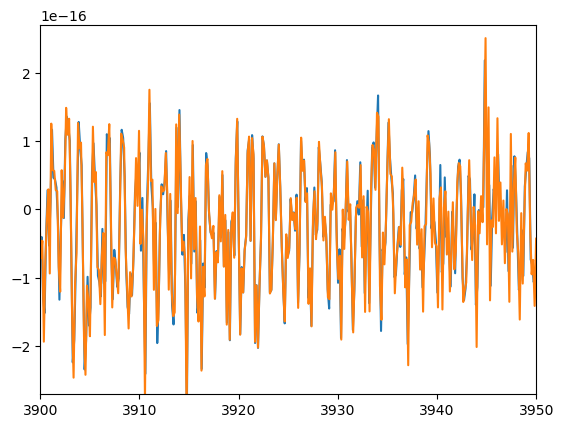

In [96]:
plt.plot(wavelengths_interp, bspl(wavelengths_interp))
plt.plot(wavelengths_array[:,0], templates[:,0])
plt.xlim(3900, 3950)
plt.ylim(-np.median(templates[:,0]),np.median(templates[:,0]))

In [99]:
templates_interp = np.zeros_like(wavelengths_array)

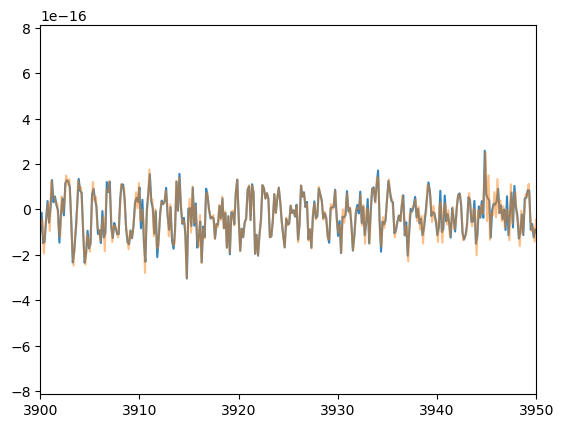

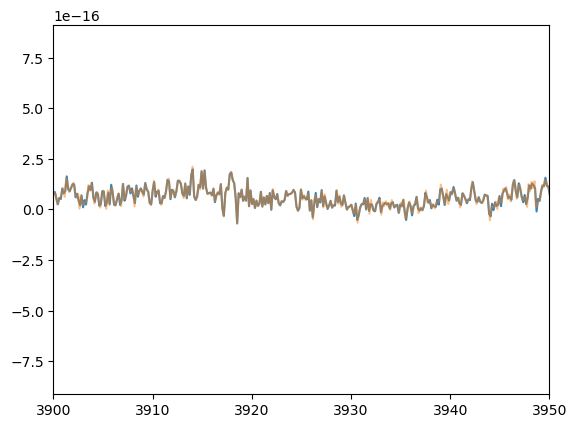

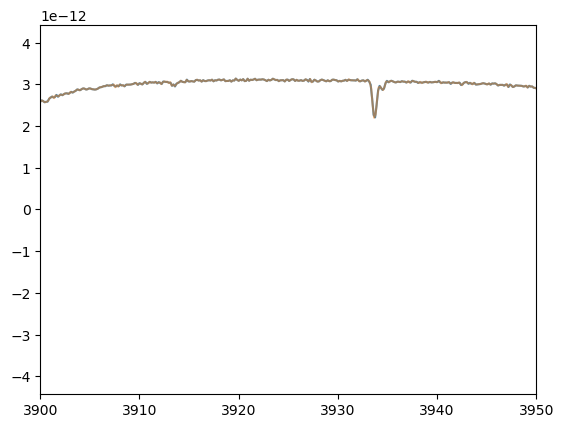

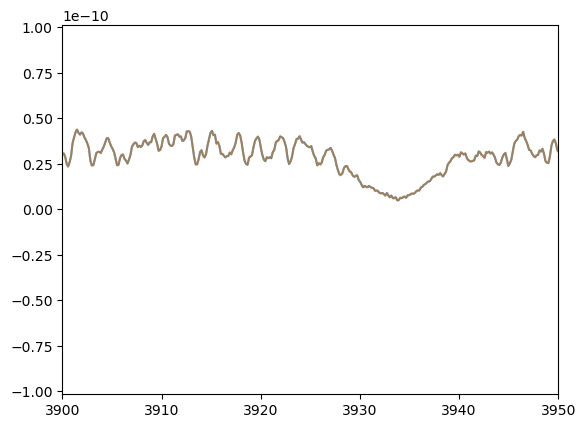

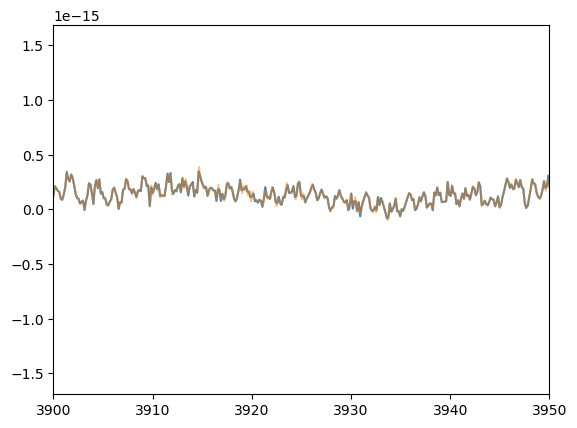

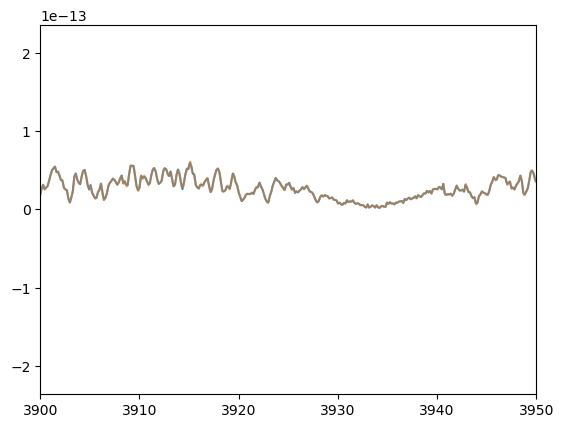

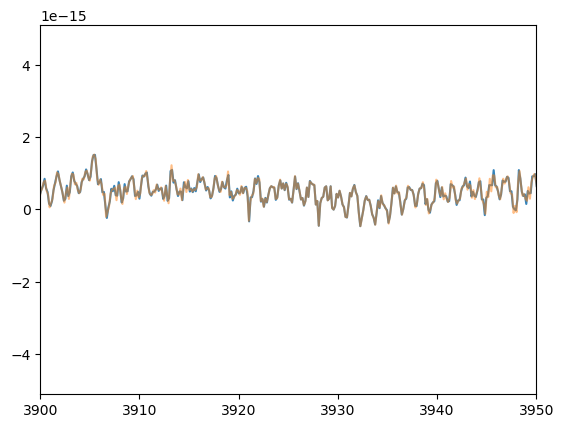

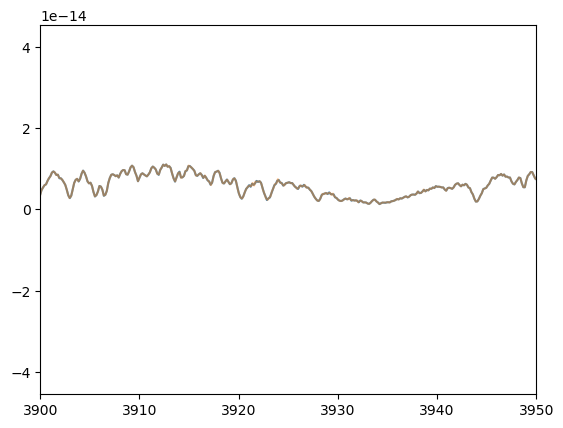

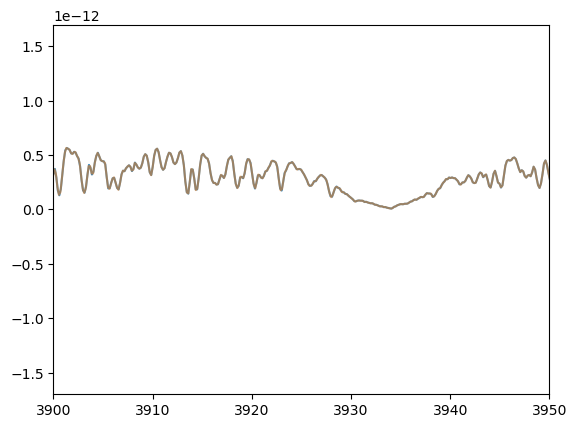

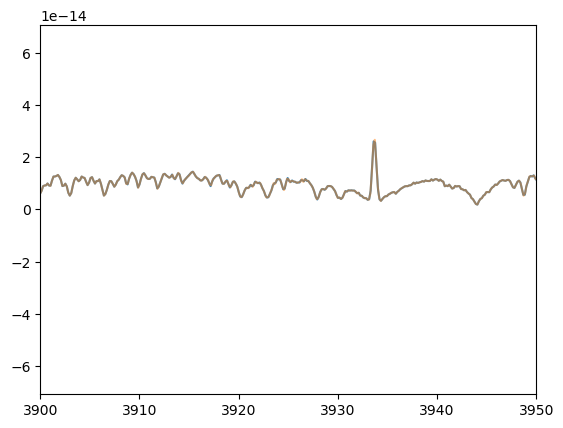

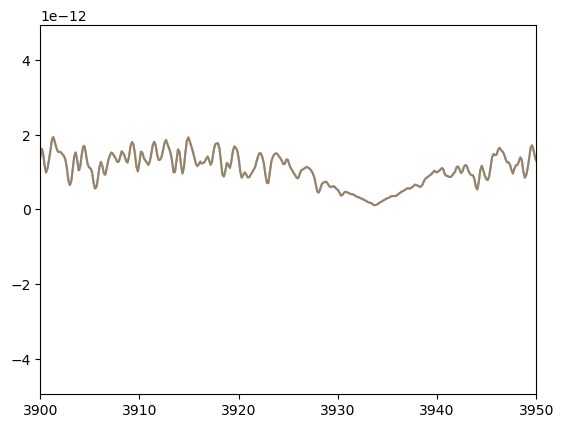

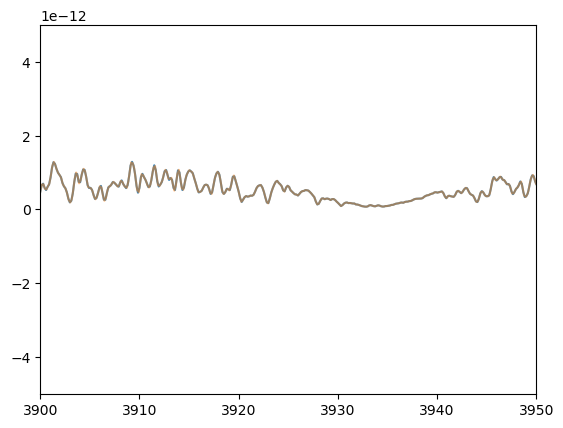

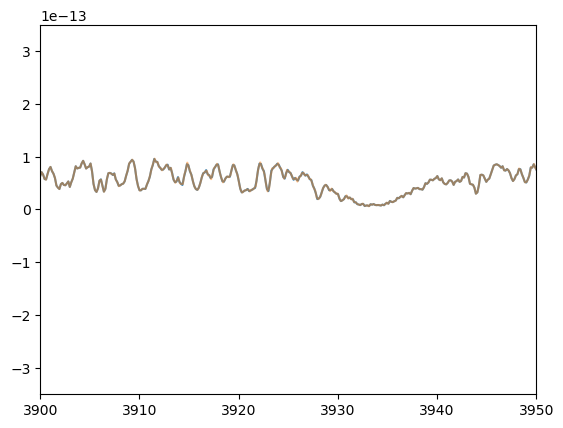

In [110]:
# Yeah this is what I need to do

for i in range(templates.shape[1]):
    
    bspl = make_interp_spline(wavelengths_array[:,i], templates[:,i], k=9)
    
    templates_interp[:,i] = bspl(wavelengths_interp)
    
    if i % 50 == 0:
        alpha=0.5
        plt.plot(wavelengths_interp, bspl(wavelengths_interp), alpha=0.9)
        plt.plot(wavelengths_array[:,i], templates[:,i], alpha=0.5)
        plt.xlim(3900, 3950)
        plt.ylim(-3*np.median(templates[:,i]),3*np.median(templates[:,i]))
        plt.pause(1)
    
    

In [111]:
# check the shape of templates
templates.shape

(17140, 628)

In [112]:
# cool, now we need to add a dimension that is lenght # metals (which are just going to be unused)
templates_array = np.expand_dims(templates_interp, axis=2)

## Add the other stuff

In [113]:
3e5/13/2.355

9799.118079372856

In [114]:
3950/9800

0.4030612244897959

In [115]:
#FWHM_tem = 0.403  # Xshooter spectra have a constant resolution FWHM of
# 1/9800*3950 = 0.403

fwhm = np.full_like(template_wavelengths, 0.403)

In [116]:
# ages are just the number of templates
ages = np.zeros(templates.shape[1])
ages.shape

(628,)

In [117]:
# metals is length 1 because I don't use it
metals = np.array([0])

In [118]:
# masses is shape (nages, nmetals)
masses = np.zeros((ages.size, metals.size))

## Save all these to a .npz file

In [119]:
# the name is basically abritrary for me, but it matches how the emiles library is loaded in
new_library_path = f'{lib_dir}spectra_xshooter_9.0.npz'

In [120]:
np.savez_compressed(
                    new_library_path,
                    templates=templates_array,
                    lam=template_wavelengths,
                    fwhm=fwhm,
                    ages=ages,
                    metals=metals,
                    masses=masses
                   )

# See if we can load it with sps_util

In [28]:
import ppxf.ppxf_util as ppxf_util
from os import path
ppxf_dir = path.dirname(path.realpath(ppxf_util.__file__))
import ppxf.sps_util as sps_util

In [29]:
# set up to load in the sps

sps_name = 'xshooter'
velscale = 60
rest_FWHM = 0.5
wave_range = [3000, 4000]

In [30]:
# bring in the templates from ppxf/sps_models/
basename = f"spectra_{sps_name}_9.0.npz"
filename = new_library_path #path.join(ppxf_dir, 'sps_models', basename)

# template library will be sampled at data resolution times the velscale_ratio in the given wavelength range
sps = sps_util.sps_lib(filename, 
                       velscale, # resolution
                       rest_FWHM, # data FWHM in restframe
                       wave_range=wave_range) # range for templates
loaded_templates= sps.templates

In [31]:
# keep templates and wavelength range of templates
loaded_templates = loaded_templates.reshape(loaded_templates.shape[0], -1) 
templates_wave = sps.lam_temp

In [32]:
# check the shapes
loaded_templates.shape

(1437, 628)

In [33]:
templates_wave.shape

(1437,)

In [34]:
templates_wave

array([3000.41312207, 3001.01368021, 3001.61435857, ..., 3997.81728747,
       3998.61748453, 3999.41784175])

# Looks like a success!

In [13]:
templates_wave.min()

3000.413122065844

In [35]:
# see if I can just load the file

a = np.load(filename)

In [39]:
a['fwhm']

array([0.403, 0.403, 0.403, ..., 0.403, 0.403, 0.403], dtype=float32)